In [1]:
from scipy.sparse import *
import numpy as np
import pickle
import random
from sklearn.decomposition import PCA
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
from scipy.sparse import csc_matrix as smatrix
import scipy

In [2]:
# load vocabulary
with open('vocab_full.pkl', 'rb') as f:
    vocab = pickle.load(f)
list(vocab.items())[:10]

[('brad', 6978),
 ('shaye', 73790),
 ('felony', 44782),
 ('asta', 78492),
 ("briana's", 99038),
 ('9155', 71962),
 ('hooky', 69828),
 ('prp', 36365),
 ('mix', 1312),
 ('phenominiall', 55861)]

In [3]:
# construct num -> word dict
reverse_dictionary = dict(zip(vocab.values(), vocab.keys()))

In [4]:
# file -> [[word_number_1_1, ..., word_number_1_K1], ..., [word_number_L_1, ..., word_number_L_KL]]
def file_to_word2numbers(filename):
    data = open(filename, 'rb')
    word2numbers_all = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        word2numbers = []
        for word in line:
            if word in vocab: word2numbers.append(vocab[word])
        if word2numbers:
            word2numbers_all.append(word2numbers)
    return word2numbers_all

In [5]:
# loading data -> numbers of words
pos_numbers = file_to_word2numbers('../data/train_pos_full.txt')
neg_numbers = file_to_word2numbers('../data/train_neg_full.txt')

1250000it [00:12, 100410.97it/s]
1250000it [00:17, 72902.70it/s]


In [6]:
len(vocab)

101299

In [7]:
word_frequency = {}

In [8]:
def word_frequency_update(numbers):
    for i, tweet in tqdm(enumerate(numbers)):
        for number in tweet:
            if number in word_frequency: word_frequency[number] += 1
            else: word_frequency[number] = 1

In [9]:
word_frequency_update(pos_numbers)
word_frequency_update(neg_numbers)

1249957it [00:04, 300761.69it/s]
1249964it [00:06, 199259.38it/s]


In [10]:
words_by_frequency = [x for x, y in sorted(list(word_frequency.items()), key = lambda x : -x[1])]

In [11]:
use_most_frequent = 10000

In [12]:
most_frequent_words = {y: words_by_frequency.index(y) for x, y in enumerate(words_by_frequency) if y < use_most_frequent}

In [13]:
# number of word occurences as embeddings (basic embeddings)
def numbers_to_dataset(numbers, use_size = -1):
    if use_size > 0:
        numbers = np.random.choice(numbers, use_size)
    tweets_embeddings = np.zeros((len(numbers), use_most_frequent), dtype=np.float32)
    for i, tweet in tqdm(enumerate(numbers)):
        for number in tweet:
            if number in most_frequent_words:
                tweets_embeddings[i, most_frequent_words[number]] += 1
    return smatrix(tweets_embeddings)

In [14]:
# applying it to numbers
use_size = 500000
pos_data = numbers_to_dataset(pos_numbers, use_size)
neg_data = numbers_to_dataset(neg_numbers, use_size)

500000it [00:29, 17110.90it/s]
500000it [00:35, 14190.79it/s]


In [15]:
# constructing X, y pair
def two_datasets_to_one(pos_data, neg_data):
    assert pos_data.shape[1] == neg_data.shape[1]
    X = scipy.sparse.vstack((pos_data, neg_data))
    y = np.array([1] * pos_data.shape[0] + [0] * neg_data.shape[0])
    assert len(y) == X.shape[0]
    assert X.shape[0] == pos_data.shape[0] + neg_data.shape[0]
    assert X.shape[1] == pos_data.shape[1]
    return X, y

In [16]:
# applying to datasets (pos & neg)
X, y = two_datasets_to_one(pos_data, neg_data)

In [17]:
clf = LogisticRegression(verbose=True, n_jobs = 8, solver = 'sag', tol = 0.001, C = 1000, max_iter = 100000)
clf.fit(X, y)

convergence after 277 epochs took 353 seconds


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  5.9min finished


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100000, multi_class='ovr',
          n_jobs=8, penalty='l2', random_state=None, solver='sag',
          tol=0.001, verbose=True, warm_start=False)

0.834812


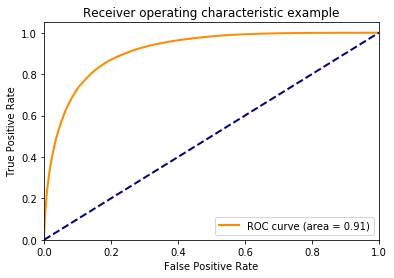

In [18]:
print(clf.score(X, y))

fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [19]:
# open train and predict
def test_to_dataset(filename):
    data = open(filename, 'rb')
    idxes = []
    tweets_embeddings = []
    
    for line in tqdm(data):
        idx, line = line.strip().decode("utf-8").split(',', 1)
        idxes.append(idx)
        line = line.split(' ')
        tweet = []
        
        tweet_embeddings = np.zeros((use_most_frequent, ), dtype=np.float32)
        
        for word in line:
            if word in vocab and vocab[word] in most_frequent_words:
                tweet_embeddings[most_frequent_words[vocab[word]]] += 1
                
        tweets_embeddings.append(tweet_embeddings)
        
    #return tweets_embeddings
    tweets_embeddings = np.array(tweets_embeddings)
    assert len(idxes) == tweets_embeddings.shape[0]
    assert tweets_embeddings.shape[1] == use_most_frequent
    return idxes, tweets_embeddings

In [20]:
idx_test, X_test = test_to_dataset('../data/test_data.txt')

10000it [00:00, 13325.15it/s]


In [21]:
y_predicted = np.array(2 * (clf.predict(X_test) - 0.5), dtype=np.int64)

In [22]:
answers = sorted(zip(idx_test, y_predicted), key = lambda x: int(x[0]))

In [23]:
f = open('submission_count_full.txt', 'w')
f.write("Id,Prediction\n")
for idx, ans in answers:
    f.write("%s,%s\n" % (idx, ans))
f.close()